# Random World Trivia

Data Source: http://api.worldbank.org

In [1]:
import numpy as np
import pandas as pd
import requests
import wbdata #Sherouse, O. (2014). Wbdata. Arlington, VA.(http://github.com/OliverSherouse/wbdata)
from datetime import datetime, timedelta

In [2]:
# Bokeh PLOTTING
from bokeh.charts import Line,  show
from bokeh.plotting import figure, ColumnDataSource
from bokeh.charts import Scatter
from bokeh.models import Range1d
from bokeh.io import output_notebook, show

# Matplotlip and seaborn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='ticks', context='talk')

### Plot 1 Labor force with Tertiary Education 

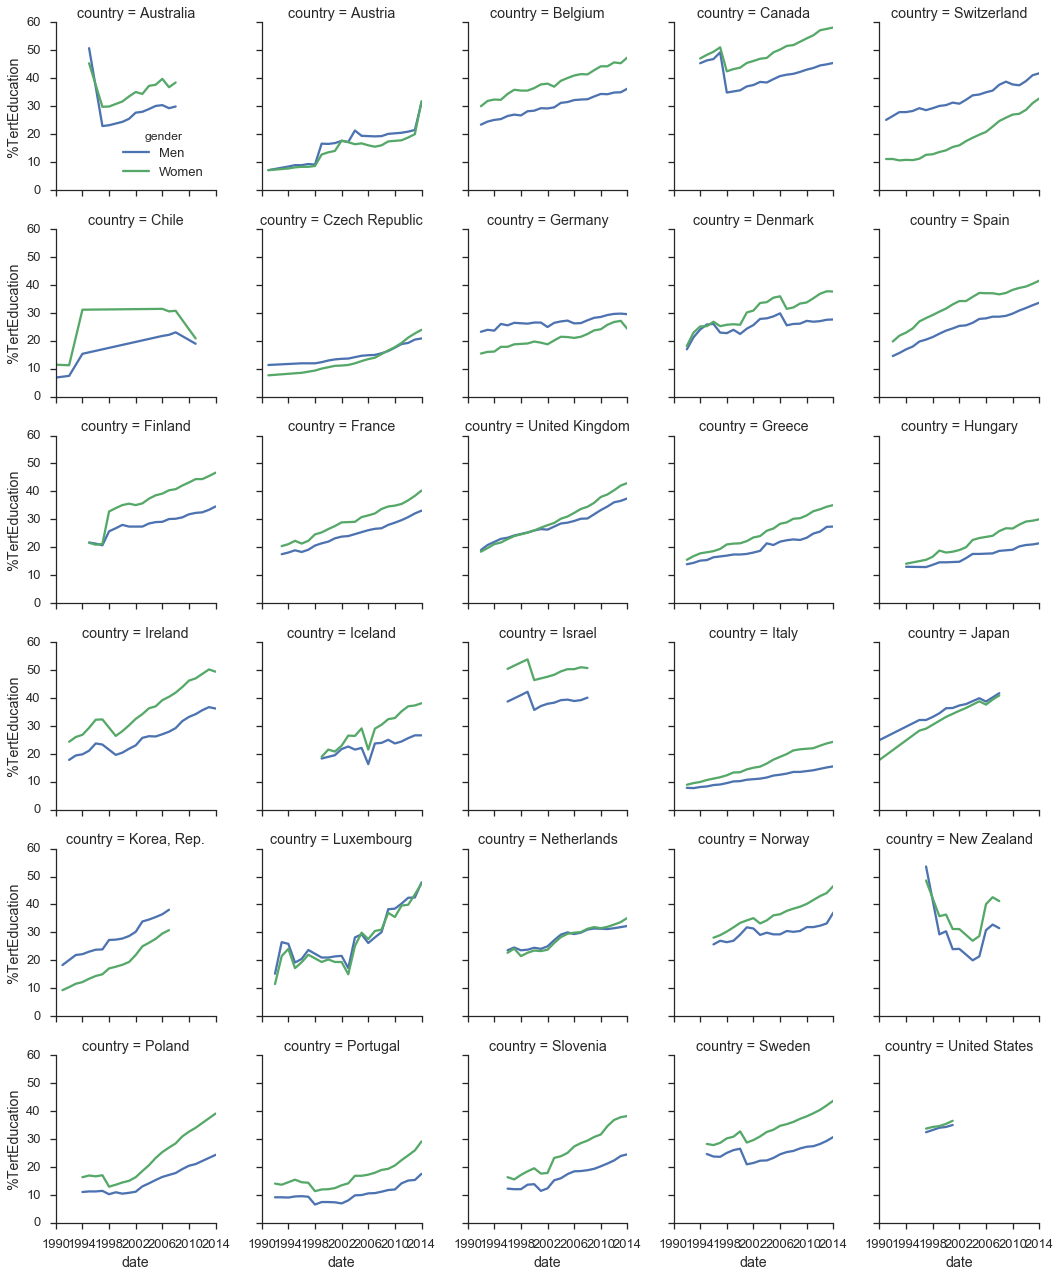

In [3]:
# Get Data
# "Labor force with tertiary education, female / male (% of f/m labor force)
indicator = {"SL.TLF.TERT.FE.ZS": "Women",
             "SL.TLF.TERT.MA.ZS": "Men"}

data_date = ( datetime(1990, 1, 1),datetime(2015, 1, 1))
df=wbdata.get_dataframe(indicator, 
                        country= ['ISL', 'ISR', 'BEL', 'AUT', 'KOR', 'POL', 'FIN','FRA','CAN', 'DEU', 
                                  'USA','NZL', 'GBR','DNK','NOR', 'AUS','ESP','IRL', 'CHE', 'CHL',
                                   'NLD', 'LUX', 'SWE', 'ITA', 'SVN','GRC', 'PRT', 'CZE', 'JPN', 'HUN'],
                         data_date=data_date, convert_date=True)
# generate a clean dataset
df.dropna(inplace=True)
df_long = pd.melt(df.reset_index(), id_vars=['date', 'country'], value_vars=['Men', 'Women'],
               value_name='%TertEducation')
df_long = df_long.rename(columns = {"variable": "gender"})


# Plotting with seaborn
g = sns.FacetGrid(df_long, col='country', col_wrap=5, hue='gender', legend_out = False)
g.map(plt.plot, 'date', '%TertEducation')
g.add_legend()
sns.set_context("notebook", font_scale=1.3)
sns.plt.show()

Some Notes on Limitations:
* The data are limited in their comparability between different countries, because The term tertiary education might mean different things in different countries. E. g. a nursing degree might count as tertiary education in one country and not in another)
* Some data look a bit conspicuous. E. g. the female labor force raise in Chile within by more than 20%-points in 2 years and similarly the huge drops of labor force with tertiary education over a short time span in e. g. Canada, New Zealand and Australia. It seems more likely that the methodology of data collection changed or the definition of what counts as tertiary education changed than an actual sudden change in tertiary education labor force.

Notes on Results:
* General tendency is that over time more and more people in the labor market have a tertiary education. 
* The vast majority of the analyzed countries show that the working women are more likely to have a completed tertiary education than the working male labor force.
* In some countries the % labor force with tertiary education between women and men are and have been in the past roughly balanced: Netherlands, Portugal, USA (though limited data!), Luxembourg, and Czech Republic
* Noteable exceptions of the general trend are Switzerland and Germany :-( where over the last years the education level of the female work force lacks behind that of the male workforce. The same is true for Korea though I would ascribe it to cultural differences and like acceptance of women as a 'working power'. 

### Plot 2: Women education and participation in labor force

In [4]:
# getting the data:
countries = [i['id'] for i in wbdata.get_country(incomelevel="OEC", display=False)]
data_date = ( datetime(2000, 1, 1),datetime(2015, 1, 1))
indicator = {"SG.GEN.LSOM.ZS": "%FemLeaders", # Female legislators, senior officials and managers (% of total)
             "SE.XPD.TOTL.GD.ZS": "EduExp", # Government expenditure on education as % of GDP (%)
             "BAR.TER.CMPT.25UP.FE.ZS": "%FemTert"} # % of female pop age 25+ with tertiary schooling Completed

df = wbdata.get_dataframe(indicator, country=countries, data_date=data_date, convert_date=True)

In [5]:
# transform and clean up data
df.dropna(inplace = True) # deletes row if one entry is NaN
df.reset_index(inplace = True)
df.loc[:,'year'] = df.ix[:,'date'].dt.year 
# keep only the latest entry for each country
idx = df.groupby(['country'])['date'].transform(max) == df['date'] 
df_tidy = df[idx]

df_tidy.head(5)


,country,date,%FemLeaders,%FemTert,EduExp,year
0,Australia,2005-01-01,35.045905,19.68,4.91079,2005
2,Austria,2010-01-01,28.917981,8.81,5.73320,2010
5,Belgium,2010-01-01,34.101935,17.77,6.39667,2010
7,Canada,2010-01-01,36.696718,27.40,5.37116,2010
10,Switzerland,2010-01-01,32.980751,15.91,4.94787,2010


In [6]:
# Bubble Chart + hoover tool
from bokeh.models import HoverTool

def bubble_plot():

    yvar =  '%FemTert'
    xvar = '%FemLeaders'
    param = 'EduExp'
    source = ColumnDataSource({'x': df_tidy[xvar], 'y':df_tidy[yvar], 
                               'country':df_tidy['country'],'year': df_tidy['year'], 
                               'param':df_tidy[param]})
    hover = HoverTool( tooltips=[
            ("Country", "@country"),
            ("% Female Leaders", "$x "),
            ("% Female w Tert Educ", "$y"), # "$y{0.0%}"
            ("EducExpenses % of GDP", "@param"),
            ("Year", "@year"),
        ] )
    TOOLS = "pan,wheel_zoom,box_zoom,reset,hover"
    b = figure(width=600, height=500, title_text_font_size='11pt',
           title="% of labor ", tools = [hover])
    b.scatter('x', 'y', alpha = 0.4, marker='circle', size = df_tidy[param]*5, source=source)
    b.text(x=21, y=33, text=["Bubble size: Educational expenses in % of GDP"],
         text_color="#444444", text_align="left", text_font_size="11pt")

    
    b.title = "Title"
    b.xaxis.axis_label = "Female legislators, sen. officials & managers (in %)"#xvar
    b.yaxis.axis_label = "% of female labor force with tertiary education"#yvar
    b.yaxis.axis_label_text_font_size = "11pt"
    b.xaxis.axis_label_text_font_size = "11pt"
    b.set(x_range=Range1d(20,45 ),  y_range=Range1d(0,35))
    return b


In [7]:
output_notebook()
b = bubble_plot()
show(b)   

Loading BokehJS ...

### Plot 3 Renewable energy consumption 

In [8]:
# EG.FEC.RNEW.ZS   "Renewable energy consumption (% of total final energy consumption)"
data_date = ( datetime(1990, 1, 1),datetime(2015, 1, 1))
VarName = "%RenewableEnergy"
dfs = wbdata.get_dataframe({"EG.FEC.RNEW.ZS": VarName}, 
                           country=['ISR', 'AUT', 'KOR','FRA','CAN', 'DEU', 'NLD',
                                    'USA','NZL','GBR','DNK','NOR', 'AUS', 'CHL','JPN'],
                           data_date=data_date, convert_date=True)
dfs.dropna(inplace=True)
Country_names=set(dfs.index.get_level_values('country'))

MyCol = ['#0000FF',  '#99DDFF', '#117733', '#BBBB55',  '#55FF55', 'Coral', '#FF0000' , '#FFFFBB',
         '#882255', '#AA4499', '#6699CC', '#6F6F6F', 'PaleVioletRed', '#BB88EE' ,'#332288' ]

p = figure(width=700, height=500, x_axis_type="datetime", title_text_font_size='12pt',
           title="Renewable energy consumption (% of energy consumption)")

for idx, c in enumerate(Country_names):
    This_col = MyCol[np.mod(idx,len(MyCol))]
    df_time_s = dfs.xs(c, level='country', axis=0, drop_level=True).dropna() 
    p.line(df_time_s.index, df_time_s[VarName], line_dash='solid', 
           line_width=3, color =This_col, legend=c )  
    
p.set(x_range=Range1d(datetime(1982, 1, 1)-timedelta(10), max(df_time_s.index)+timedelta(300)), 
      y_range=Range1d(0,62))
p.legend.location = "left_center"
p.legend.label_text_font_size = "10pt"
p.legend.border_line_color = None
p.legend.legend_spacing= 0
p.xaxis.axis_label = 'Year'
p.yaxis.axis_label_text_font_size = "10pt"
p.yaxis.axis_label = "% Renewable energy consumption"

output_notebook()
show(p)

Loading BokehJS ...

In [7]:
# some indicators:
indicators = {
"FP.CPI.TOTL":                	"Consumer price index (2010 = 100)",
*"FP.CPI.TOTL.ZG":             	"Inflation, consumer prices (annual %)",
"NY.GDP.MKTP.KD.ZG":          	"GDP growth (annual %)",
*"SI.POV.GINI":                	"GINI index (World Bank estimate)",
*"SE.TER.ENRR" :               "Gross enrolment ratio, tertiary, both sexes (%)",
*"BAR.TER.CMPT.25UP.FE.ZS":  "% of female pop age 25+ with tertiary schooling Completed",
*"BAR.TER.CMPT.25UP.ZS":     "% of population age 25+ with tertiary schooling Completed",
"SE.ENR.TERT.FM.ZS":       "Gross enrolment ratio, tertiary, gender parity index (GPI)", # **
"SE.TER.ENRR":             "Gross enrolment ratio, tertiary, both sexes (%)",
"SE.TER.ENRR.FE":        	"Gross enrolment ratio, tertiary, female (%)",
"SE.TER.ENRR.MA":       	"Gross enrolment ratio, tertiary, male (%)",
*"SE.XPD.TOTL.GD.ZS":    	"Government expenditure on education as % of GDP (%)", # ***
*"SG.GEN.LSOM.ZS":       	"Female legislators, senior officials and managers (% of total)", # ***
"SG.GEN.PARL.ZS":       	"Proportion of seats held by women in national parliaments (%)",
"SL.TLF.TERT.FE.ZS":    	"Labor force with tertiary education, female (% of female labor force)",
"SL.TLF.TERT.MA.ZS":    	"Labor force with tertiary education, male (% of male labor force)",
"SL.TLF.TERT.ZS":       	"Labor force with tertiary education (% of total)",
"SL.TLF.TOTL.FE.ZS":    	"Labor force, female (% of total labor force)", #  ***
"SP.DYN.TFRT.IN":       	"Fertility rate, total (births per woman)", #  ***
"ccx_lf_pop_fem":       	"Labor Force Participation rates - female"
}